# Classification of Industrial Works

In [ ]:
# ! pip install -r requirements

In [ ]:
# ! pip install torch

In [17]:
from scipy.special import softmax

In [2]:
import re
import torch
import random
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.special import softmax

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from pymystem3 import Mystem

from simpletransformers.classification import MultiLabelClassificationModel, ClassificationModel

nltk.download('punkt')
nltk.download('wordnet')

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

stop = stopwords.words('russian')
# df = pd.read_csv("lab2_oil_gas_field_construction_data.csv")
# feature = "work_name"
df = pd.read_csv("corrected_df.csv")
feature = "corrected_work_name"
target = "generalized_work_class"
val_size = 0.2
seed = 42
seed_all(seed)
use_cuda = torch.cuda.is_available()
my_stem = Mystem()


/Users/ellkrauze/projects/ITMO/classification_of_industrial_works/industrial-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/ellkrauze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ellkrauze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

def word_lemmatizer(text):
    # lem_text = [my_stem.lemmatize(i) for i in text]
    lem_text = my_stem.lemmatize(text)
    return lem_text

def preprocess(x):
    x = re.sub(r"(@[А-Яа-я0-9]+)|([^0-9А-Яа-я \t\n])|(\w+:\/\/\S+)|^rt|http.+?", "", x)
    x = re.sub(r"\d+", "", x)
    x = ' '.join([word for word in x.split() if word not in (stop)])
    x = word_tokenize(x)
    x = ' '.join(x)
    x = word_lemmatizer(x)
    x = ' '.join(x).rstrip()
    return x

def clean_text(df_values):
    return df_values.str.lower().apply(lambda x: preprocess(x))
        # .apply(lambda elem: re.sub(r"(@[А-Яа-я0-9]+)|([^0-9А-Яа-я \t\n])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))\
        # .apply(lambda elem: re.sub(r"\d+", "", elem))\
        # .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))\
        # .apply(lambda x: word_tokenize(x))\
        # .apply(lambda x: ' '.join(x)) \
        # .apply(lambda x: word_lemmatizer(x))\
        # .apply(lambda x: ' '.join(x)) \
        # .apply(lambda x: x.rstrip())\
        # .apply(lambda x: spell(x))


In [6]:
df = df.drop_duplicates()

In [7]:
predictions_df = df[df[target].isna()] # Empty `target` column

train_df = df[~df[target].isna()]

lbl = preprocessing.LabelEncoder()

# Encode categorical labels (`target`)
train_df[target] = lbl.fit_transform(train_df[target].values.astype('str'))

train_df = train_df[[feature, target]].rename(columns={feature: "text", target: "label"})
train_df["text"] = clean_text(train_df["text"])

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df["text"], train_df["label"], test_size=val_size, random_state=seed) 

Explore the dataset.

In [58]:
train_df.drop_duplicates().groupby(by="label")["label"].count().sort_values(ascending=False)

label
139    884
123    470
171    430
144    348
149    341
      ... 
61       1
55       1
48       1
45       1
32       1
Name: label, Length: 207, dtype: int64

In [57]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print(f"Number of '{target}' classes:", len(y_train.unique()))
print(f"Average number of words per `{feature}` sample:", get_num_words_per_sample(X_train.values))
print(f"Number of samples per'{target}' in the dataset:", train_df.groupby(by="label")["label"].count().sort_values(ascending=False))

Training set size: 237486
Validation set size: 59372
Number of 'generalized_work_class' classes: 206
Average number of words per `corrected_work_name` sample: 3.0
Number of samples per'generalized_work_class' in the dataset: label
139    26081
123    21547
171    20943
192    16096
2      13918
       ...  
40         2
62         2
48         1
45         1
164        1
Name: label, Length: 207, dtype: int64


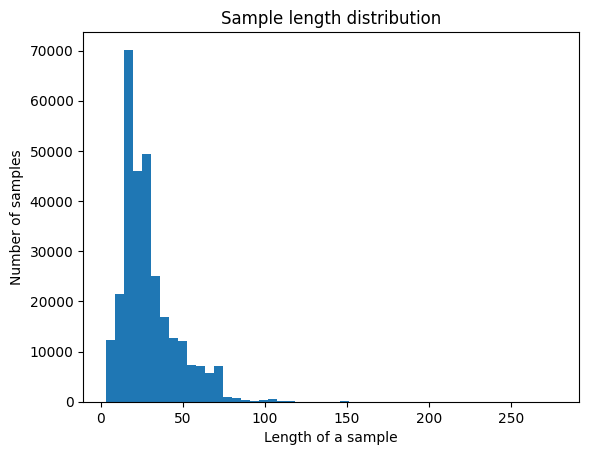

In [ ]:
# https://developers.google.com/machine-learning/guides/text-classification/step-2-5
plot_sample_length_distribution(train_df[feature].values)

In [92]:
# Observe data
print(X_train[10:20])

32041     пт ол поз экз внутренней поверхности резервуара
215123                     устройство песчаной подготовки
206302                       укладка футляра диаметром мм
9771             изоляция сварных стыков трубопровода ду 
136187                                монтаж ростверка рм
65477                                    обратная засыпка
253235                бурение скважины протектор д мм l м
89916                                     монтаж арматуры
117690                                                пор
183112                             бетонная подготовка б 
Name: corrected_work_name, dtype: object


In [10]:
train = pd.DataFrame(data = {"text": X_train, "label": y_train})
val = pd.DataFrame(data = {"text": X_val, "label": y_val})
train

,text,label
13797,монтаж заземление,140
285192,монтаж заземлять перемычка,140
7818,пора,188
26304,монтаж трубопровод стабилизировать устро...,171
49432,разработка корыто дорожный одежда,198
...,...,...
119879,обратный засыпка пазуха скважина грави...,181
259178,погружение свая,192
131932,разработка грунт траншея,198
146867,забивка свая,192


# Model

In [19]:
# model = ClassificationModel(
#     'roberta', 
#     'roberta-base', 
#     use_cuda=use_cuda,
#     num_labels= train_df['label'].nunique(), 
#     args={
#         'train_batch_size':32,
#         # 'reprocess_input_data': True,
#         'reprocess_input_data': False,
#         'overwrite_output_dir': True,
#         'fp16': False,
#         'do_lower_case': False,
#         'num_train_epochs': 1,
#         'max_seq_length': 256,
#         'regression': False,
#         'manual_seed': seed,
#         "learning_rate":5e-4,
#         'weight_decay':0.0,
#         "save_eval_checkpoints": False,
#         "save_model_every_epoch": False,
#         "silent": False
#     }
# )

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ! export TOKENIZERS_PARALLELISM=false
# model.train_model(train, eval_df=val)

# Load model

Training was performed using Google Colab resources. Model's progress was saved in `outputs` folder which is loaded as a checkpoint below.

In [11]:
num_labels = train_df['label'].nunique()
print(num_labels)

207


In [13]:
model = ClassificationModel(
    'roberta', 
    'outputs/', 
    use_cuda=use_cuda,
    num_labels = num_labels, 
    args={
        'train_batch_size':32,
        'reprocess_input_data': True,
        # 'reprocess_input_data': False,
        'overwrite_output_dir': True,
        'fp16': False,
        'do_lower_case': False,
        'num_train_epochs': 1,
        'max_seq_length': 150,
        'regression': False,
        'manual_seed': seed,
        "learning_rate":5e-5,
        'weight_decay':0.0,
        "save_eval_checkpoints": False,
        "save_model_every_epoch": False,
        "silent": False
    }
)

### Validation

In [15]:
result_val, model_outputs_val, wrong_preds_val = model.eval_model(val)

/Users/ellkrauze/projects/ITMO/classification_of_industrial_works/industrial-env/lib/python3.11/site-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
  0%|          | 0/59372 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running Evaluation: 100%|██████████| 7422/7422 [58:08<00:00,  2.13it/s] 


In [18]:
preds_tmp_val = softmax(model_outputs_val, axis=1)
preds_val = [np.argmax(x) for x in preds_tmp_val]

In [19]:
model.compute_metrics(preds_val, model_outputs_val, labels=y_val)

({'mcc': 0.9886828152975421}, ['NA'])

### Test data

In [29]:
df_test = pd.read_csv("lab2_test_dataset.csv", sep=';')
df_test = df_test.dropna()
test = df_test.rename(columns={"work_name": "text", "generalized_work_class": "label_text" })
test["label"] = lbl.transform(test["label_text"])
test = test[["text", "label"]]

test["text"] = clean_text(test["text"])

In [31]:
result_test, model_outputs_test, wrong_preds_test = model.eval_model(test)

/Users/ellkrauze/projects/ITMO/classification_of_industrial_works/industrial-env/lib/python3.11/site-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
  0%|          | 0/197902 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Running Evaluation: 100%|██████████| 24738/24738 [3:09:35<00:00,  2.17it/s]  


In [38]:
preds_tmp_test = softmax(model_outputs_test, axis=1)
preds_test = [np.argmax(x) for x in preds_tmp_test]

In [39]:
model.compute_metrics(preds_test, model_outputs_test, labels=test["label"])

({'mcc': 0.9761436852565957}, ['NA'])

In [41]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [45]:
np.array(preds_val).shape

(59372,)

In [48]:
model_outputs_test.shape

(197902, 207)

### Results

In [ ]:
roc_auc_score(labels, softmax(model_outputs, axis=1)[:,1])

In [86]:
y_val.shape

(59372,)

In [85]:
softmax(model_outputs_val, axis=1).shape

(59372, 207)

In [87]:
from sklearn.metrics import accuracy_score, roc_auc_score
print(f"Validation accuracy:", accuracy_score(y_val, preds_val))
print(f"Test accuracy:", accuracy_score(test["label"], preds_test))

# print(f"Validation accuracy:", roc_auc_score(
#     y_val, softmax(model_outputs_val, axis=1)[:,1], 
#     average='macro', multi_class='ovr'))

# print(f"Validation accuracy:", roc_auc_score(
#     y_val, model_outputs_val, 
#     multi_class='ovr'))

Validation accuracy: 0.9890857643333558
Test accuracy: 0.9769785045123344


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [ ]:

print(f"Test accuracy:", roc_auc_score(test["label"], model_outputs_test,average='macro', multi_class='ovr'))

In [51]:
print(f"Validation logloss:", multiclass_logloss(y_val, model_outputs_val, eps=1e-15))
print(f"Test logloss:", multiclass_logloss(test["label"], model_outputs_test, eps=1e-15))

Validation logloss: 0.026405376790313267
Test logloss: 0.04162040752503296


### Model Description

In [75]:
model.config

RobertaConfig {
  "_name_or_path": "outputs/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
 